# Image Classification Project

## 1. Import Required Libraries

In [2]:
import sys
print(sys.version)
print(sys.executable)

3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
c:\Users\Admin\Downloads\Task5\.venv\Scripts\python.exe


In [2]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import os

## 2. Load and Explore the Dataset

In [3]:
# Load CIFAR-10 Dataset
import pickle

def load_cifar10_batch(batch_filename):
    with open(batch_filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        data = batch[b'data']
        labels = batch[b'labels']
        return data, labels

def load_cifar10_dataset(data_dir):
    X_train = []
    y_train = []
    for i in range(1, 6):
        data, labels = load_cifar10_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.extend(labels)
    X_train = np.concatenate(X_train)
    y_train = np.array(y_train)
    X_test, y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_train, y_train, X_test, y_test

# Set data directory
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_cifar10_dataset(cifar10_dir)

print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Number of classes: {len(np.unique(y_train))}')

C:\Users\Admin\AppData\Local\Temp\ipykernel_8672\548602535.py:6: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  batch = pickle.load(f, encoding='bytes')


Training data shape: (50000, 3072)
Test data shape: (10000, 3072)
Number of classes: 10


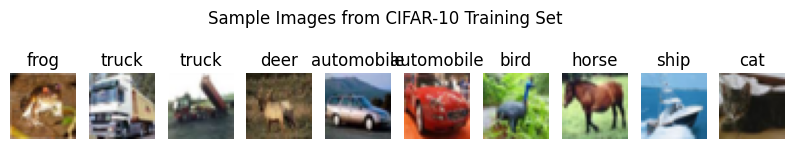

In [4]:
# Display some sample images from the training set
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 2))
for i in range(10):
    img = X_train[i].reshape(3, 32, 32).transpose(1, 2, 0)
    plt.subplot(1, 10, i+1)
    plt.imshow(img)
    plt.title(label_names[y_train[i]])
    plt.axis('off')
plt.suptitle('Sample Images from CIFAR-10 Training Set')
plt.show()

## 3. Image Preprocessing (Resize, Normalization)

normalize the pixel values to the range [0, 1] and reshape the data for both traditional ML and deep learning models.

In [5]:
# Normalize pixel values to [0, 1]
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# For CNN: reshape to (num_samples, 32, 32, 3)
X_train_cnn = X_train_norm.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
X_test_cnn = X_test_norm.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# For Logistic Regression: flatten images
X_train_flat = X_train_norm.reshape(X_train_norm.shape[0], -1)
X_test_flat = X_test_norm.reshape(X_test_norm.shape[0], -1)

print(f'CNN input shape: {X_train_cnn.shape}')
print(f'Logistic Regression input shape: {X_train_flat.shape}')

CNN input shape: (50000, 32, 32, 3)
Logistic Regression input shape: (50000, 3072)


## 4. Split Dataset into Train and Test Sets

In [6]:
# Split training data into train and validation sets using numpy (no sklearn)
def custom_train_val_split(X, y, val_ratio=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    val_size = int(X.shape[0] * val_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    return X[train_indices], X[val_indices], y[train_indices], y[val_indices]

# For flat data (Logistic Regression)
X_train_flat_sub, X_val_flat, y_train_sub, y_val = custom_train_val_split(X_train_flat, y_train, val_ratio=0.2, random_state=42)

# For CNN data
X_train_cnn_sub, X_val_cnn, y_train_cnn_sub, y_val_cnn = custom_train_val_split(X_train_cnn, y_train, val_ratio=0.2, random_state=42)

print(f'Train set shape (flat): {X_train_flat_sub.shape}')
print(f'Validation set shape (flat): {X_val_flat.shape}')
print(f'Train set shape (cnn): {X_train_cnn_sub.shape}')
print(f'Validation set shape (cnn): {X_val_cnn.shape}')

Train set shape (flat): (40000, 3072)
Validation set shape (flat): (10000, 3072)
Train set shape (cnn): (40000, 32, 32, 3)
Validation set shape (cnn): (10000, 32, 32, 3)


## 5. Train Convolutional Neural Network (CNN) Model

In [7]:
# Build a simple CNN model
cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the CNN model
history = cnn_model.fit(
    X_train_cnn_sub, y_train_cnn_sub,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_cnn, y_val_cnn)
)

c:\Users\Admin\Downloads\Task5\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.4243 - loss: 1.5929 - val_accuracy: 0.5124 - val_loss: 1.3493
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5594 - loss: 1.2512 - val_accuracy: 0.5937 - val_loss: 1.1606
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.6170 - loss: 1.1037 - val_accuracy: 0.6307 - val_loss: 1.0740
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6492 - loss: 1.0135 - val_accuracy: 0.6343 - val_loss: 1.0420
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6739 - loss: 0.9413 - val_accuracy: 0.6595 - val_loss: 0.9768
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.6916 - loss: 0.8906 - val_accuracy: 0.6625 - val_loss: 0.9788
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7101 - loss: 0.8437 - val_accuracy: 0.6733 - val_loss: 0.9505
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.7217 - loss: 0.8051 - 

## 6. Evaluate CNN Model: Accuracy and Confusion Matrix

evaluate the CNN model on the test set, compute accuracy scores, and display the confusion matrix.

Test Accuracy (CNN): 0.6902
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


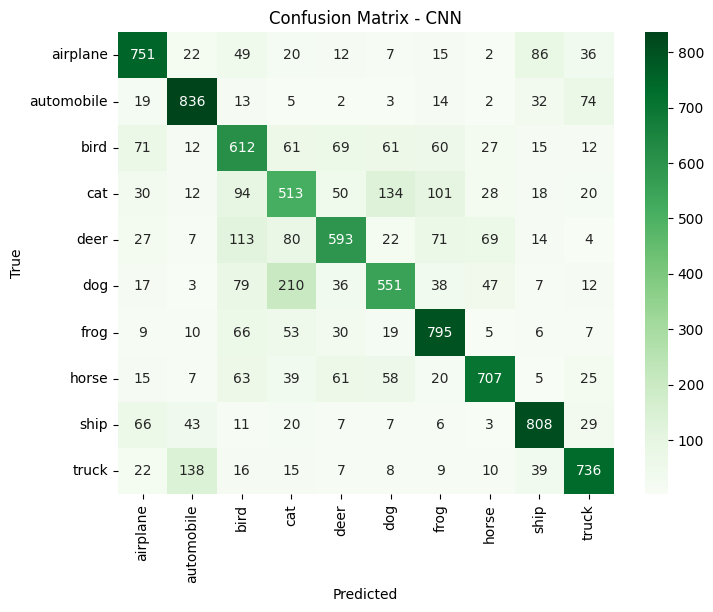

In [11]:
# Evaluate CNN on test set
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f'Test Accuracy (CNN): {cnn_test_acc:.4f}')

# Confusion matrix for CNN (manual implementation, no sklearn)
cnn_test_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
def compute_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

cm_cnn = compute_confusion_matrix(y_test, cnn_test_pred, num_classes=10)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Save the trained CNN model for deployment
cnn_model.save('cnn_cifar10_model.h5')
print('Model saved as cnn_cifar10_model.h5')

## 7. Plot Training vs Validation Accuracy

plot the training and validation accuracy curves for the CNN model to visualize its learning progress.

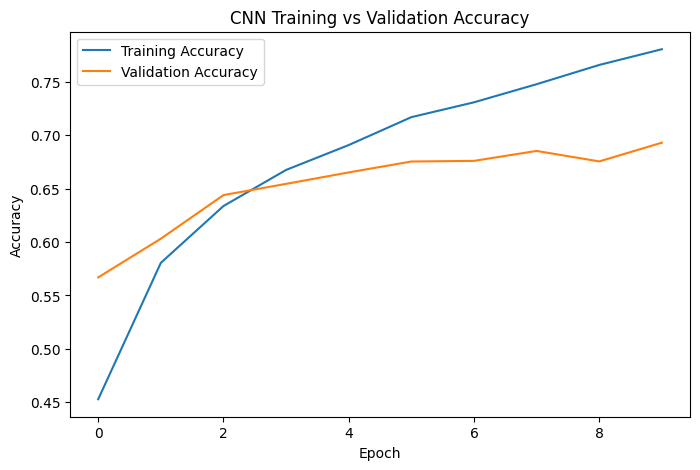

In [12]:
# Plot training and validation accuracy for CNN
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Analysis and Visualizations


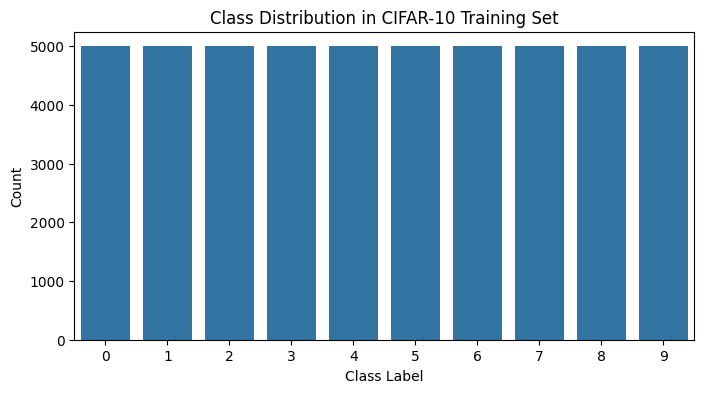

In [8]:
# Visualize class distribution in the training set
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.countplot(x=y_train)
plt.title('Class Distribution in CIFAR-10 Training Set')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


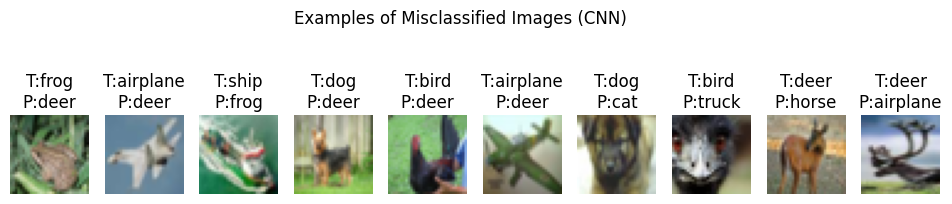

In [10]:
# Visualize some misclassified images from the CNN model
try:
    cnn_test_pred
except NameError:
    cnn_test_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

misclassified_idxs = np.where(cnn_test_pred != y_test)[0][:10]
plt.figure(figsize=(12, 3))
for i, idx in enumerate(misclassified_idxs):
    img = X_test_cnn[idx]
    plt.subplot(1, 10, i+1)
    plt.imshow(img)
    plt.title(f'T:{label_names[y_test[idx]]}\nP:{label_names[cnn_test_pred[idx]]}')
    plt.axis('off')
plt.suptitle('Examples of Misclassified Images (CNN)')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


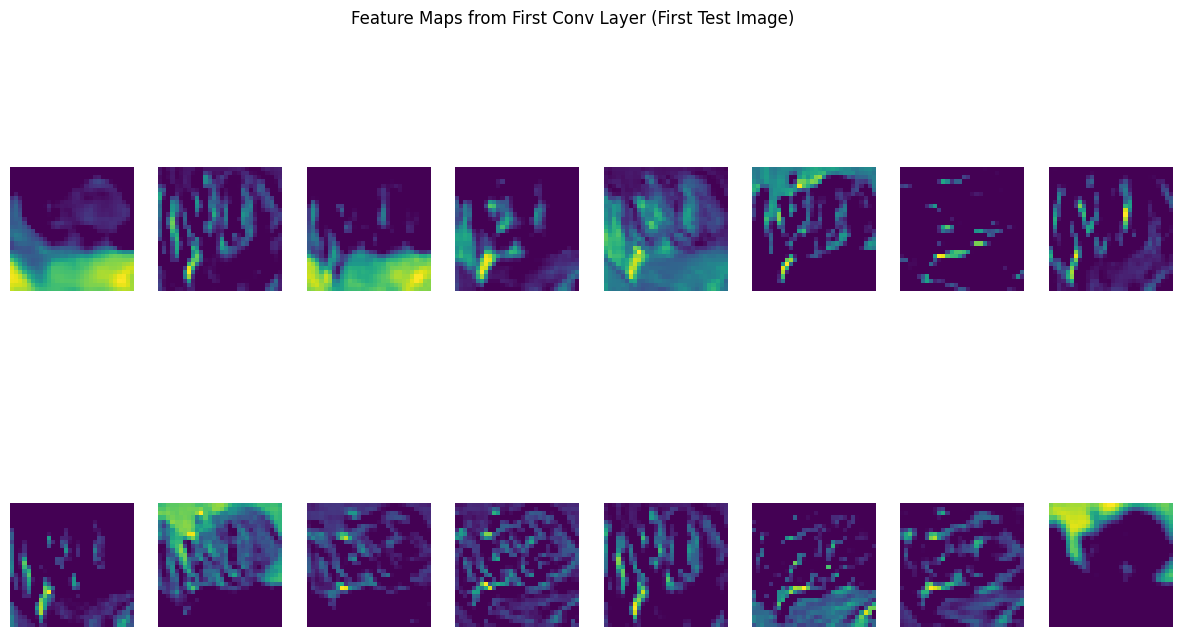

In [ ]:
# Visualize feature maps from the first convolutional layer of the CNN model
from tensorflow.keras import models

if not hasattr(cnn_model, 'input') or cnn_model.input is None:
    # Recreate the model using the Functional API for reliable input access
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    functional_model = keras.Model(inputs=inputs, outputs=outputs)
    # Copy weights from the sequential model if possible
    try:
        for l_seq, l_func in zip(cnn_model.layers, functional_model.layers[1:]):
            l_func.set_weights(l_seq.get_weights())
    except Exception as e:
        print('Warning: Could not copy weights:', e)
    model_for_vis = functional_model
else:
    model_for_vis = cnn_model

layer_outputs = [layer.output for layer in model_for_vis.layers if 'conv' in layer.name]
activation_model = models.Model(inputs=model_for_vis.input, outputs=layer_outputs)
activations = activation_model.predict(X_test_cnn[:1])

# Plot the feature maps of the first conv layer
first_layer_activation = activations[0]
plt.figure(figsize=(15, 8))
for i in range(min(16, first_layer_activation.shape[-1])):
    plt.subplot(2, 8, i+1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Feature Maps from First Conv Layer (First Test Image)')
plt.show()